# PRÁCTICA 2: Desarrollo de una aplicación de Procesamiento del Lenguaje Natural


### Anton Oksymets

Lo primero de todo es crear un entorno aparte, a priori no estoy seguro de lo que librerias voy a utilizar pero voy a hacer un entorno base con unas librerias base que voy a usar

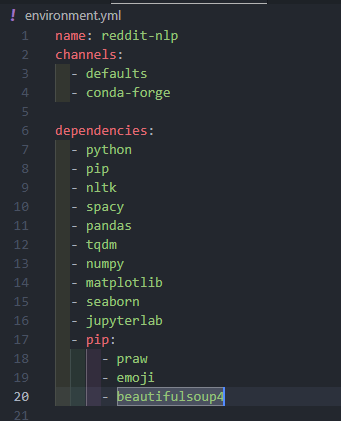

En este docuento podemos ver las librerias base para el jupiter notebook, librerias para graficar, librerias para analizar textos y alguna librerias de emojis(para hacer mas adelante el preprocesado)

Creo el entorno escribiendo en cmd: 
- conda env create -f environment.yml

Activo el entorno :
- conda activate reddit-nlp


Lo primero de todo es obtener la Api y empezar a descargar de alli los hilos para los proximos ejercicios:

In [ ]:
import praw

user_agent = "Scraper 1.0 by /u/w4ity"
reddit = praw.Reddit(
    client_id='_1WWMBLxGyn2mxo-xkDA4g',
    client_secret='nPQt-evDLFlh-9KUm5Sws-Uf_M1zqw', 
    user_agent=user_agent
)

La siguiente celda es para verificar si puedo acceder a ese hilo, ya que intenté acceder a unos hilo pero al procesarlos me salía el documento en blanco

In [ ]:
from prawcore.exceptions import Forbidden, NotFound, Redirect

nombre_subreddit = "movies"
try:
    subreddit = reddit.subreddit(nombre_subreddit)
    # fuerza una consulta para comprobar acceso
    subreddit.id
    print(f"✅ El subreddit r/{nombre_subreddit} es accesible")
except Forbidden:
    print(f"🔒 El subreddit r/{nombre_subreddit} es PRIVADO o restringido")
except NotFound:
    print(f"❌ El subreddit r/{nombre_subreddit} no existe o ha sido eliminado")
except Redirect:
    print(f"❌ El subreddit r/{nombre_subreddit} redirige (posiblemente eliminado)")
except Exception as e:
    print(f"⚠️ Error inesperado: {e}")


✅ El subreddit r/movies es accesible


Importo los datos:

In [18]:
import json
from datetime import datetime

subreddits = ['spain', 'gaming', 'pcgaming', 'Fitness', 'Python', 'movies']
resultados = {}

for subreddit_name in subreddits:
    subreddit = reddit.subreddit(subreddit_name)
    resultados[subreddit_name] = []

    for submission in subreddit.top(limit=20, time_filter='week'):
        if submission.num_comments < 10 or submission.selftext == '':
            continue
        
        submission.comments.replace_more(limit=0)
        comentarios = []
        for comment in submission.comments[:50]:  # máximo 50 comentarios por hilo
            if comment.body and not comment.body.startswith("http"):
                comentario_fecha = datetime.utcfromtimestamp(comment.created_utc).isoformat()  # Convertir el timestamp en fecha legible
                comentarios.append({
                    "user": comment.author.name if comment.author else "anonymous",
                    "comment": comment.body,
                    "score": comment.score,
                    "date": comentario_fecha  # en formato ISO
                })
        
        resultados[subreddit_name].append({
            "flair": submission.link_flair_text,
            "title": submission.title,
            "author": submission.author.name if submission.author else "anonymous",
            "date": datetime.utcfromtimestamp(submission.created_utc).isoformat(),
            "score": submission.score,
            "description": submission.selftext,
            "comments": comentarios
        })

    # Guardar cada subreddit en un archivo JSON
    with open(f'ejemplo_rubreddit_{subreddit_name}.json', 'w', encoding='utf-8') as f:
        json.dump(resultados[subreddit_name], f, ensure_ascii=False, indent=2)


C:\Users\hdhfh\AppData\Local\Temp\ipykernel_6188\338012542.py:19: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  comentario_fecha = datetime.utcfromtimestamp(comment.created_utc).isoformat()  # Convertir el timestamp en fecha legible
C:\Users\hdhfh\AppData\Local\Temp\ipykernel_6188\338012542.py:31: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "date": datetime.utcfromtimestamp(submission.created_utc).isoformat(),


Tras descargar los documentos, los voy a procesar, he creado varias funciones que he visto que aparecen en los hilos y he intentado limpiar lo maximo; para limpiar los emojis que estan en Unicode he utilizado esta pagina para ver los emojis y poner los rangos: https://www.webfx.com/tools/emoji-cheat-sheet/

In [25]:
import os
import json
import pandas as pd
import string
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Descargar recursos necesarios de NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

# Inicializar herramientas
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Funciones de preprocesado
def remove_newlines(text):
    return text.replace('\n', ' ').replace('\r', ' ')

def remove_emojis(text):
    emoji_pattern = re.compile(
        u'['
        u'\U0001F600-\U0001F64F'  # Emoticonos
        u'\U0001F300-\U0001F5FF'  # Símbolos y pictogramas
        u'\U0001F680-\U0001F6FF'  # Transporte y mapas
        u'\U0001F700-\U0001F77F'  # Alquimia
        u'\U0001F780-\U0001F7FF'  # Geometría
        u'\U0001F800-\U0001F8FF'  # Símbolos adicionales
        u'\U0001F900-\U0001F9FF'  # Emoticonos adicionales
        u'\U0001FA00-\U0001FA6F'  # Emoticonos adicionales
        u'\U0001FA70-\U0001FAFF'  # Símbolos nuevos
        u'\U00002702-\U000027B0'  # Símbolos diversos
        u'\U000024C2-\U0001F251'  # Caracteres suplementarios
        u'\U00010000-\U0010FFFF'  # Rango completo de emojis
        ']+', flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

def remove_punctuation(text):
    return "".join([ch for ch in text if ch not in string.punctuation])

def remove_urls(text):
    return re.sub(r'http\S+', '', text)

def remove_mentions(text):
    return re.sub(r'@\w+', '', text)

def tolower(text):
    return text.lower()

def tokenize(text):
    return text.split()

def remove_stopwords(tokens):
    return [t for t in tokens if t not in stop_words]

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

def preprocesado(text):
    text = remove_newlines(text)
    text = remove_emojis(text)
    text = remove_punctuation(text)
    text = remove_urls(text)
    text = remove_mentions(text)
    text = tolower(text)
    tokens = tokenize(text)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize_tokens(tokens)
    return tokens

# Lista de subreddits que usaste
subreddits = ['spain', 'gaming', 'pcgaming', 'Fitness', 'Python', 'movies']

# Procesar cada archivo
for subreddit in subreddits:
    filename = f'ejemplo_rubreddit_{subreddit}.json'

    if not os.path.exists(filename):
        print(f"[✘] Archivo no encontrado: {filename}")
        continue

    with open(filename, 'r', encoding='utf-8') as f:
        data = json.load(f)

    comentarios = []
    for hilo in data:
        for com in hilo['comments']:
            comentarios.append({
                'subreddit': subreddit,
                'text': com['comment'],
                'fecha': com['date']
            })

    df = pd.DataFrame(comentarios)

    # Procesamiento de texto
    df['tokens'] = df['text'].apply(preprocesado)

    #print(df.head())

    # Guardar el DataFrame procesado en un archivo CSV
    df.to_csv(f'procesado_{subreddit}.csv', index=False)

    print(f"[✔] Procesado {subreddit} con {len(df)} comentarios.")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hdhfh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hdhfh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hdhfh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hdhfh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[✔] Procesado spain con 143 comentarios.
[✔] Procesado gaming con 250 comentarios.
[✔] Procesado pcgaming con 50 comentarios.
[✔] Procesado Fitness con 340 comentarios.
[✔] Procesado Python con 184 comentarios.
[✔] Procesado movies con 100 comentarios.


## 2 Clasificador de comentarios en subreddits (3,0 puntos).

Cargar todos los CSVs procesados:

In [5]:
import pandas as pd
import os

subreddits = ['spain', 'gaming', 'pcgaming', 'Fitness', 'Python', 'movies']
dfs = []

for subreddit in subreddits:
    filename = f'procesado_{subreddit}.csv'
    if not os.path.exists(filename):
        print(f"Archivo no encontrado: {filename}")
        continue
    df = pd.read_csv(filename)
    df['label'] = subreddit  # Añadir columna de etiqueta
    dfs.append(df)

# Concatenar todos los comentarios
df_all = pd.concat(dfs, ignore_index=True)

Crear conjunto de entrenamiento y validación (70% - 30%)

Importar Sklearn: conda install -c conda-forge scikit-learn

In [6]:
from sklearn.model_selection import train_test_split

df_all = df_all[df_all['text'].notnull() & (df_all['text'] != '[removed]') & (df_all['text'] != '[deleted]')]

# Dividir por hilos (usando el título como identificador único)
grouped = df_all.groupby('text')['label'].first().reset_index()
train_threads, val_threads = train_test_split(grouped, test_size=0.3, stratify=grouped['label'], random_state=42)

# Filtrar comentarios según los hilos seleccionados
train_df = df_all[df_all['text'].isin(train_threads['text'])]
val_df = df_all[df_all['text'].isin(val_threads['text'])]

X_train = train_df['tokens']
y_train = train_df['label']

X_val = val_df['tokens']
y_val = val_df['label']


## Sistema 1: TF-IDF + SVM 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import ast #para transferir los datos a python de manera mas facil, es una libreria nativa 

# Función para convertir cadena a tokens
def join_tokens(tokens_str):
    try:
        tokens_list = ast.literal_eval(tokens_str)
        return " ".join(tokens_list)  # => 'egolifting watching someone else egolifting pathetic'
    except:
        return ""

# Aplicar transformación
X_train_text = X_train.apply(join_tokens)
X_val_text = X_val.apply(join_tokens)

# Entrenar modelo 
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
clf = LinearSVC()

pipeline = Pipeline([
    ('tfidf', vectorizer),
    ('clf', clf)
])

pipeline.fit(X_train_text, y_train)
preds = pipeline.predict(X_val_text)

print(classification_report(y_val, preds))


# Puedo observar que la presicion en pcgaiming es de 1, 
#eso tiene pinta de  overfitting por tanto voy a probar mejorar el modelo para que esto no suceda

              precision    recall  f1-score   support

     Fitness       0.90      0.90      0.90        81
      Python       0.84      0.88      0.86        56
      gaming       0.70      0.86      0.77        74
      movies       0.96      0.77      0.85        30
    pcgaming       1.00      0.67      0.80        15
       spain       0.94      0.74      0.83        42

    accuracy                           0.84       298
   macro avg       0.89      0.80      0.84       298
weighted avg       0.86      0.84      0.84       298



Añado validacion cruzada, matrices de confusion y balanceo los conjuntos con un undersampling 

pip install imbalanced-learn

Cross-validation scores: [0.85714286 0.76190476 0.78571429 0.71428571 0.76190476]
Mean CV score: 0.78
              precision    recall  f1-score   support

     Fitness       0.92      0.88      0.90        81
      Python       0.79      0.80      0.80        56
      gaming       0.86      0.65      0.74        74
      movies       0.62      0.87      0.72        30
    pcgaming       0.59      0.87      0.70        15
       spain       0.77      0.81      0.79        42

    accuracy                           0.80       298
   macro avg       0.76      0.81      0.77       298
weighted avg       0.81      0.80      0.80       298



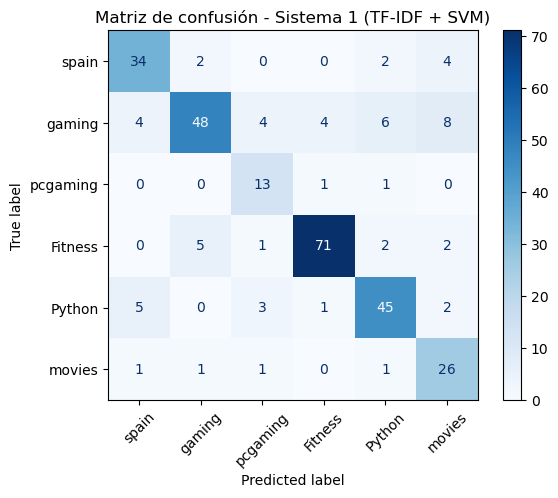

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Función para convertir cadena a tokens
def join_tokens(tokens_str):
    try:
        tokens_list = ast.literal_eval(tokens_str)
        return " ".join(tokens_list)
    except:
        return ""

# Aplicar transformación
X_train_text = X_train.apply(join_tokens)
X_val_text = X_val.apply(join_tokens)

# Balanceo de clases
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_text.to_frame(), y_train)

# Vectorizador
vectorizer = TfidfVectorizer()
clf = LinearSVC(C=0.1, penalty='l2', loss='squared_hinge', dual=False, max_iter=1000)

pipeline = Pipeline([
    ('tfidf', vectorizer),
    ('clf', clf)
])

# Validación cruzada
cv_scores = cross_val_score(pipeline, X_resampled.values.ravel(), y_resampled, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.2f}")

# Entrenar y evaluar
pipeline.fit(X_resampled.values.ravel(), y_resampled)
preds = pipeline.predict(X_val_text)

# Informe de clasificación
print(classification_report(y_val, preds))

# Matriz de confusión
cm = confusion_matrix(y_val, preds, labels=subreddits)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=subreddits)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.title("Matriz de confusión - Sistema 1 (TF-IDF + SVM)")
plt.show()

#Cuadrdo eso para la futura comparacion>
preds_svm = pipeline.predict(X_val_text)
y_val_svm = y_val.copy()

Primeras puedo observar que las muestras de la clase fitness se clasifican muy bien, con un accuracy de 92%

Voy a representarlo en 2D para ver mejor la separabilidad

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

def plot_pca(X, y, title_pca="PCA Visualization"):
    # Codificar etiquetas categóricas
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    classes = le.classes_

    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X.toarray())  # Si es sparse matrix

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='tab20', alpha=0.7, s=20)
    plt.title(title_pca)
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.legend(handles=scatter.legend_elements()[0], labels=list(classes), title="Subreddits")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

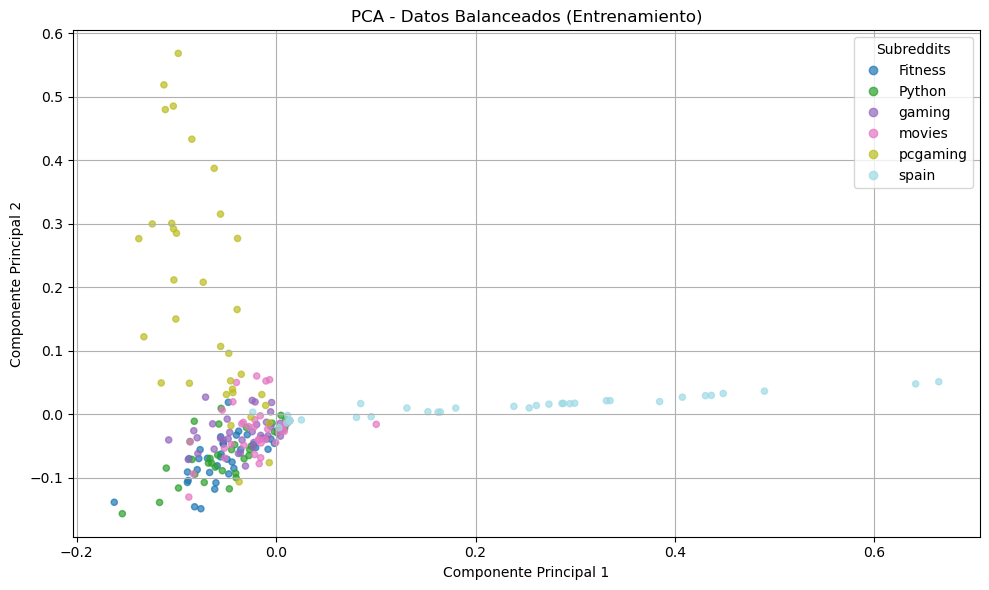

In [10]:
# Transformar los datos resampleados y validación
X_resampled_tfidf = vectorizer.transform(X_resampled.values.ravel())
X_val_tfidf = vectorizer.transform(X_val_text)

plot_pca(
    X_resampled_tfidf,
    y_resampled,
    title_pca="PCA - Datos Balanceados (Entrenamiento)"
)

Se puede obervar que con los datos de entrenamiento se ve clramente la separabiliodad entre los redits de 'pcgaming' y 'spain'

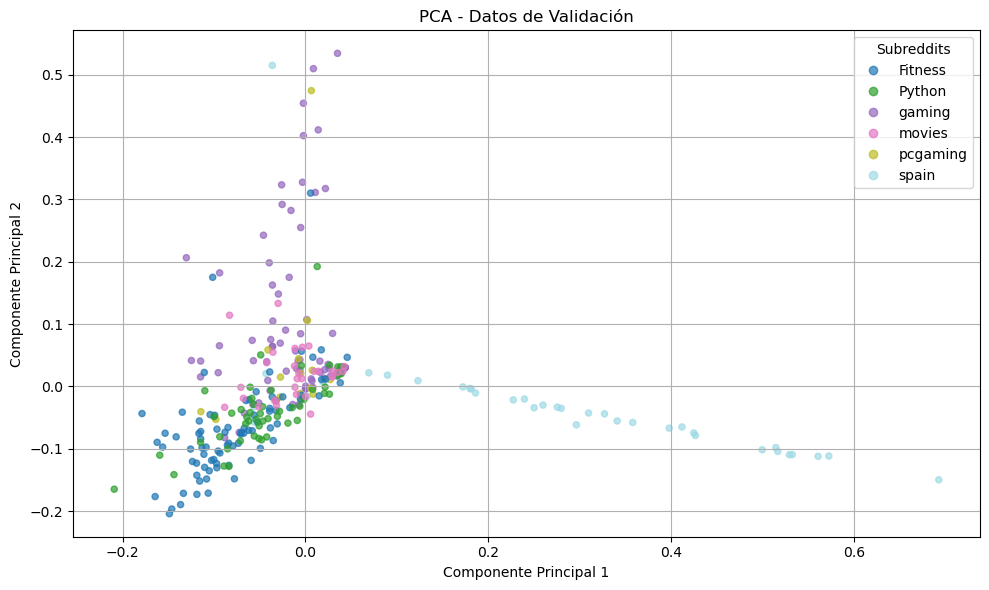

In [13]:
plot_pca(
    X_val_tfidf,
    y_val,
    title_pca="PCA - Datos de Validación"
)

MIentras que con los datos validados se observa mas que la separación clara viene por 'gaming' y 'spain' 

## Sitema 2 Glove y SVM

- Para hacer la parte de Glove, me he ido a la pagina oficial : https://nlp.stanford.edu/projects/glove/ 

- Me he descargado el modelo : Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download): glove.6B.zip

Pesa alrededor de unos 800MB por tanto no lo voy a incluir en el comprimido de la entrega 

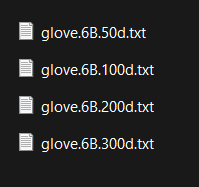

He decidido probar con el mas pequeño que es el de 50 dimensiones y con el de 300 dimensiones 

Cargar los embeddings con Glove:

In [ ]:
import numpy as np
import os
import ast

def load_glove_embeddings(glove_path):
    embeddings = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    print(f"Se cargaron {len(embeddings)} palabras.")
    return embeddings

glove_path = 'C:/Users/hdhfh/Documents/Practica2PLN/glove.6B.50d.txt' 
glove_embeddings = load_glove_embeddings(glove_path)

Se cargaron 400000 palabras.


Informe de clasificación:
              precision    recall  f1-score   support

     Fitness       0.81      0.85      0.83        81
      Python       0.80      0.79      0.79        56
      gaming       0.59      0.86      0.70        74
      movies       0.85      0.37      0.51        30
    pcgaming       1.00      0.13      0.24        15
       spain       0.91      0.74      0.82        42

    accuracy                           0.74       298
   macro avg       0.83      0.62      0.65       298
weighted avg       0.78      0.74      0.73       298



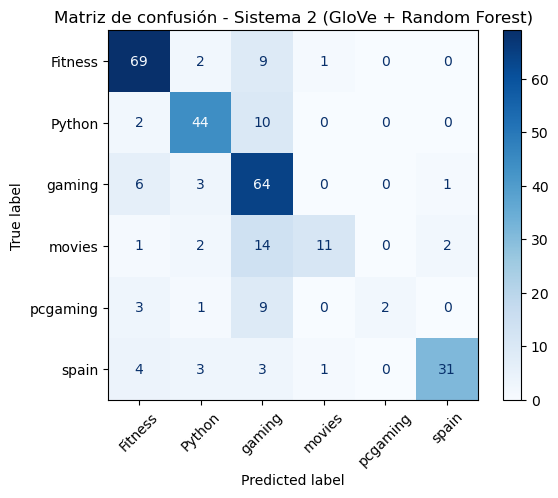

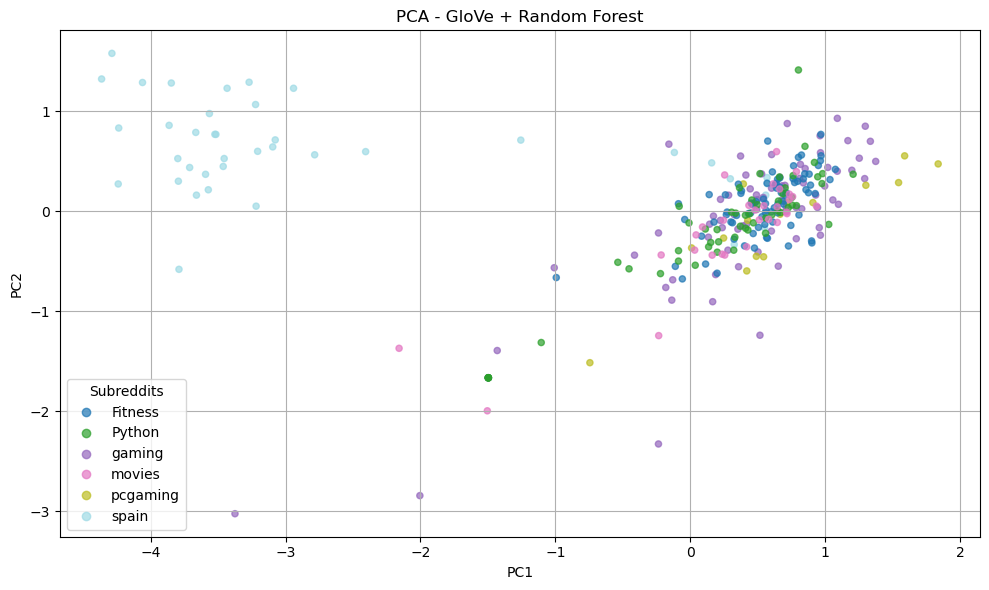

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

def get_embedding(tokens_str, embeddings, dim=50):
    try:
        tokens = ast.literal_eval(tokens_str)  # Convierte cadena a lista
        vectors = [embeddings[token] for token in tokens if token in embeddings]
        if not vectors:
            return np.zeros(dim)
        return np.mean(vectors, axis=0).astype(np.float32)
    except Exception as e:
        print(f"[ERROR] Procesando: {tokens_str} - {e}")
        return np.zeros(dim)

X_train_list = []
for i, x in enumerate(X_train):
    emb = get_embedding(x, glove_embeddings, dim=50)
    X_train_list.append(emb)

X_train_emb = np.vstack(X_train_list)

X_val_list = []
for i, x in enumerate(X_val):
    emb = get_embedding(x, glove_embeddings, dim=50)
    X_val_list.append(emb)

X_val_emb = np.vstack(X_val_list)

# Entrenar modelo
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train_emb, y_train)

preds = clf.predict(X_val_emb)

print("Informe de clasificación:")
print(classification_report(y_val, preds))

ConfusionMatrixDisplay.from_predictions(y_val, preds, display_labels=np.unique(y_val), cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.title("Matriz de confusión - Sistema 2 (GloVe + Random Forest)")
plt.show()

# Visualización con PCA
def plot_pca(X, y, title="PCA - GloVe Embeddings"):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    classes = le.classes_

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='tab20', alpha=0.7, s=20)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(handles=scatter.legend_elements()[0], labels=list(classes), title="Subreddits")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pca(X_val_emb, y_val, title="PCA - GloVe + Random Forest")


#Para una futura compracion>
preds_glove_50d = clf.predict(X_val_emb)
y_val_glove_50d = y_val.copy()

Ahora con 300 dimensiones:

In [ ]:
import numpy as np
import os
import ast

def load_glove_embeddings(glove_path):
    embeddings = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    print(f"Se cargaron {len(embeddings)} palabras.")
    return embeddings

glove_path = 'C:/Users/hdhfh/Documents/Practica2PLN/glove.6B.300d.txt' 
glove_embeddings = load_glove_embeddings(glove_path)

Se cargaron 400000 palabras.


Informe de clasificación:
              precision    recall  f1-score   support

     Fitness       0.86      0.90      0.88        81
      Python       0.81      0.86      0.83        56
      gaming       0.57      0.85      0.68        74
      movies       0.89      0.27      0.41        30
    pcgaming       1.00      0.20      0.33        15
       spain       0.97      0.71      0.82        42

    accuracy                           0.76       298
   macro avg       0.85      0.63      0.66       298
weighted avg       0.80      0.76      0.74       298



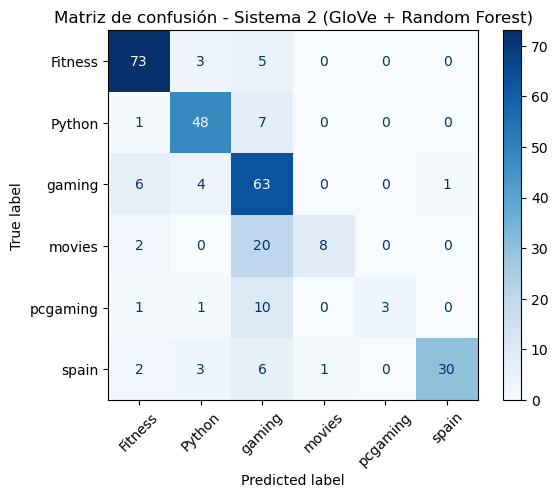

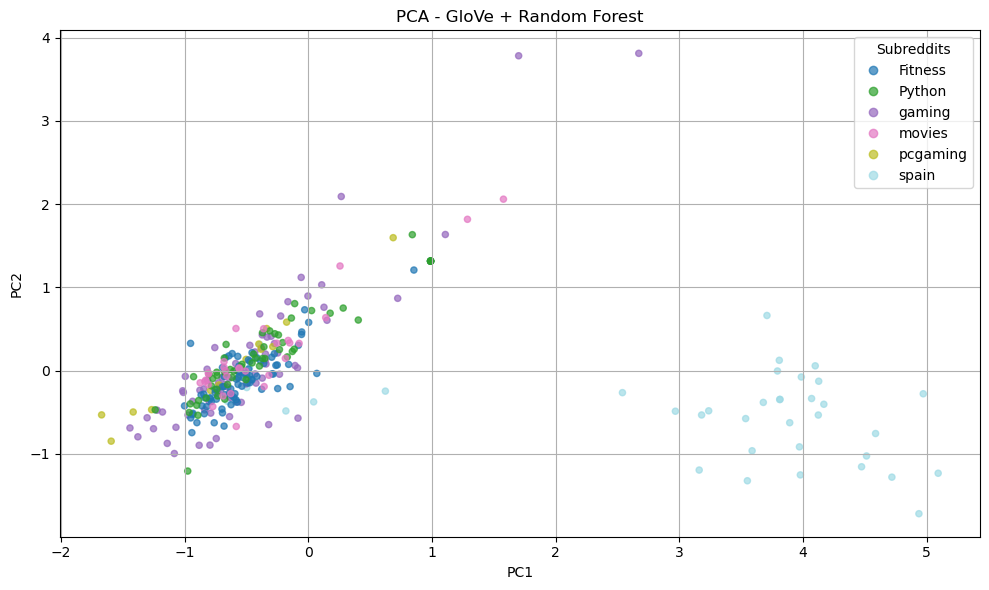

In [ ]:
def get_embedding(tokens_str, embeddings, dim=300):
    try:
        tokens = ast.literal_eval(tokens_str)  # Convierte cadena a lista
        vectors = [embeddings[token] for token in tokens if token in embeddings]
        if not vectors:
            return np.zeros(dim)
        return np.mean(vectors, axis=0).astype(np.float32)
    except Exception as e:
        print(f"[ERROR] Procesando: {tokens_str} - {e}")
        return np.zeros(dim)
# 
X_train_list = []
for i, x in enumerate(X_train):
    emb = get_embedding(x, glove_embeddings, dim=300)
    X_train_list.append(emb)

X_train_emb = np.vstack(X_train_list)

X_val_list = []
for i, x in enumerate(X_val):
    emb = get_embedding(x, glove_embeddings, dim=300)
    X_val_list.append(emb)

X_val_emb = np.vstack(X_val_list)

# Entrenar modelo

clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train_emb, y_train)

preds = clf.predict(X_val_emb)

print("Informe de clasificación:")
print(classification_report(y_val, preds))

ConfusionMatrixDisplay.from_predictions(y_val, preds, display_labels=np.unique(y_val), cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.title("Matriz de confusión - Sistema 2 (GloVe + Random Forest)")
plt.show()

# Visualización con PCA
def plot_pca(X, y, title="PCA - GloVe Embeddings"):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    classes = le.classes_

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='tab20', alpha=0.7, s=20)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(handles=scatter.legend_elements()[0], labels=list(classes), title="Subreddits")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pca(X_val_emb, y_val, title="PCA - GloVe + Random Forest")
#Para una futura comparacion>
preds_glove_300d = clf.predict(X_val_emb)
y_val_glove_300d = y_val.copy()

Comparativa:

50: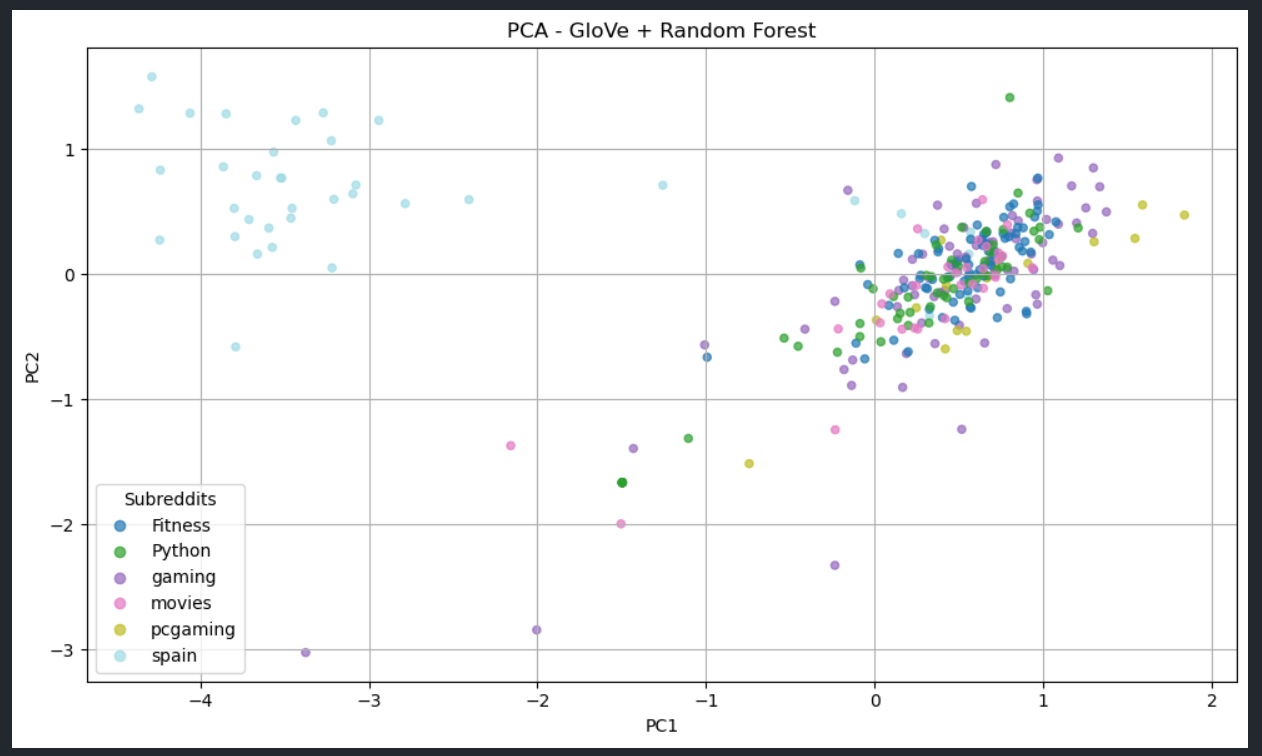        
300: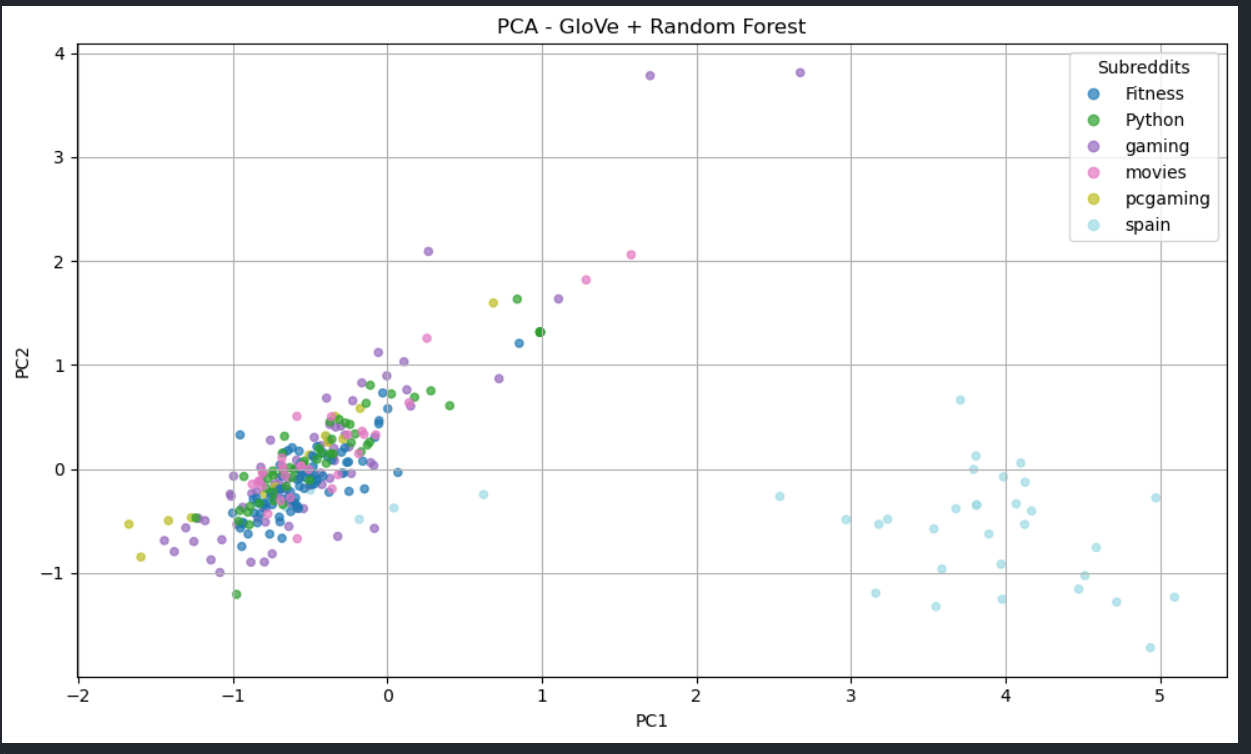

Se puede observar que en ambos casos la clase que mas se separa es la'spain' ya que tiene palabras en otro idioma a diferencia de las otras clases.

## Sistema 3: Bert + fine-tuning

Preparacion de datos:

conda install datasets

Cargar tokenizer y modelo base:

conda install transformers

Convertir labels a numéricas:

- Tengo una tarjeta NVIDIA y windows me he instalado esto: pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 

In [18]:
import torch
print("Versión de PyTorch:", torch.__version__)
print("CUDA disponible?:", torch.cuda.is_available())

Versión de PyTorch: 2.7.0+cu118
CUDA disponible?: True


Configurar entrenamiento:

pip install transformers huggingface_hub bitsandbytes

In [22]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

c:\Users\hdhfh\miniconda3\envs\reddit-nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Aqui tuve unos problemas para que me funcione pero al final si ha funcionado

pip install "accelerate>=0.26.0"

pip install transformers[torch]

In [ ]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import classification_report

#Preparar los datos
def join_tokens(tokens_str):
    try:
        tokens_list = ast.literal_eval(tokens_str)
        return " ".join(tokens_list)
    except:
        return ""

X_train_text = X_train.apply(join_tokens)
X_val_text = X_val.apply(join_tokens)

train_df = pd.DataFrame({"text": X_train_text, "label": y_train})
val_df = pd.DataFrame({"text": X_val_text, "label": y_val})

ds_train = Dataset.from_pandas(train_df)
ds_val = Dataset.from_pandas(val_df)

dataset = DatasetDict({
    "train": ds_train,
    "validation": ds_val
})

# Tokenizar los datos

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Codificar las etiquetas

le = LabelEncoder()
all_labels = pd.concat([y_train, y_val])
le.fit(all_labels)

def encode_labels(examples):
    examples["labels"] = le.transform(examples["label"])
    return examples

tokenized_datasets = tokenized_datasets.map(encode_labels, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["label", "text"])

#Cargar modelo
num_labels = len(le.classes_)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=num_labels
)

# Configurar entrenamiento

training_args = TrainingArguments(
    output_dir="./results_bert",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    report_to="none",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
)

trainer.train()

# Evaluar resultados
predictions = trainer.predict(tokenized_datasets["validation"])
preds = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

print("Informe de clasificación:")
print(classification_report(true_labels, preds, target_names=le.classes_))

#Para una compracion global>
preds_bert = np.argmax(predictions.predictions, axis=-1)
true_labels_bert = predictions.label_ids

Map: 100%|██████████| 298/298 [00:00<00:00, 66003.20 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\hdhfh\miniconda3\envs\reddit-nlp\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\hdhfh\AppData\Local\Temp\ipykernel_21176\2017740619.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.224900,1.120294
2,0.810600,0.739618
3,0.580900,0.629720
4,0.481000,0.602381


Informe de clasificación:
              precision    recall  f1-score   support

     Fitness       0.96      0.94      0.95        81
      Python       0.80      0.86      0.83        56
      gaming       0.68      0.91      0.77        74
      movies       0.88      0.73      0.80        30
    pcgaming       0.00      0.00      0.00        15
       spain       0.94      0.79      0.86        42

    accuracy                           0.83       298
   macro avg       0.71      0.70      0.70       298
weighted avg       0.80      0.83      0.81       298



c:\Users\hdhfh\miniconda3\envs\reddit-nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hdhfh\miniconda3\envs\reddit-nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hdhfh\miniconda3\envs\reddit-nlp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

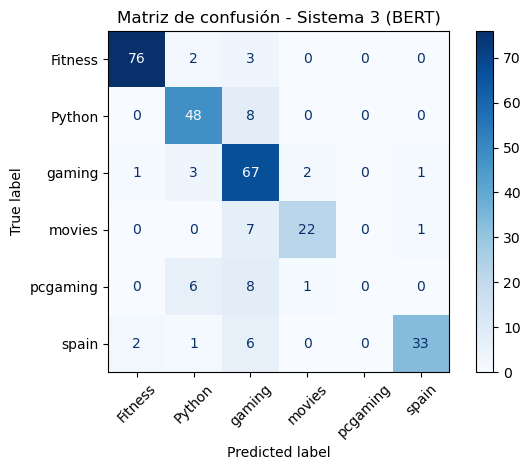

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Matriz de confusión - Sistema 3 (BERT)")
plt.tight_layout()
plt.show()

Se puede observa que el Sistema 3 clasifica muy bien la clase 'Fitness' con un accuracy de 96%, un poquito mejor que el Sistema 1 (92%)

Comparacion de los tres modelos:

Tabla comparativa de modelos:
                    Accuracy  F1 Macro  F1 Weighted
TF-IDF + SVM            0.80      0.77         0.80
GloVe 50d + RF          0.74      0.65         0.73
GloVe 300d + RF         0.76      0.66         0.74
BERT + Fine-tuning      0.83      0.70         0.81


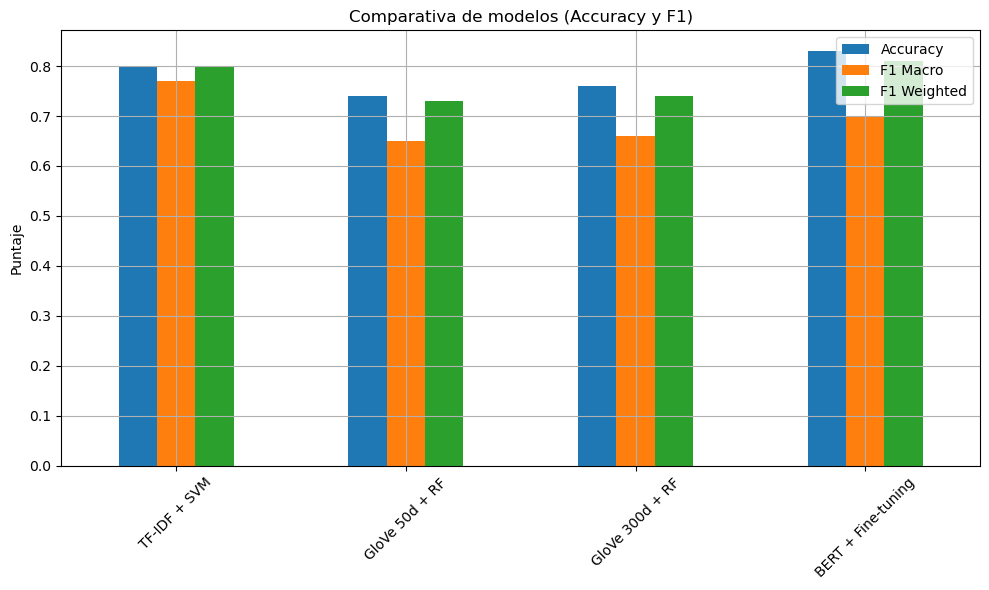

In [27]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt

# Reentrenar el label encoder con todas las etiquetas
le = LabelEncoder()
all_labels = pd.concat([y_train, y_val])
le.fit(all_labels)

# Codificar etiquetas verdaderas (y_true) como números
y_true_encoded = le.transform(y_val)

# Asegurarse de codificar TODAS las predicciones también
preds_svm_encoded = le.transform(preds_svm)
preds_glove_50d_encoded = le.transform(preds_glove_50d)
preds_glove_300d_encoded = le.transform(preds_glove_300d)
preds_bert_encoded = preds_bert  # Ya están en valores numéricos del label encoder

def get_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 Macro": f1_score(y_true, y_pred, average='macro'),
        "F1 Weighted": f1_score(y_true, y_pred, average='weighted')
    }

# Crear tabla comparativa
results = {
    "TF-IDF + SVM": get_metrics(y_true_encoded, preds_svm_encoded),
    "GloVe 50d + RF": get_metrics(y_true_encoded, preds_glove_50d_encoded),
    "GloVe 300d + RF": get_metrics(y_true_encoded, preds_glove_300d_encoded),
    "BERT + Fine-tuning": get_metrics(y_true_encoded, preds_bert_encoded)
}

# Mostrar tabla
results_df = pd.DataFrame(results).T.round(2)
print("Tabla comparativa de modelos:")
print(results_df.to_string(index=True))

# Graficar resultados
results_df.plot(kind='bar', figsize=(10,6), title='Comparativa de modelos (Accuracy y F1)')
plt.ylabel('Puntaje')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


- Se puede observar que el accuracy mas alto es el del modelo de Bert con fine-tuning
- F1 macro, calcular F1 para cada clase y promediar, se oberva que los serultados son mas precisos con el modelo de TF-IDF con SVM
- F1 Weighted, es lo mismo que F1 macro solo que ponderando cada clase, las clases que tienen mas muestras son las que tienen un mayor peso; En este apecro destaca el Sistema 3 y el Sistema 1

Si tuviera que elegir un modelo, como sé que las clases estan balancedas la medida de accuracy y la F1 macro son las dos valiosas.
Personalmente optaría por el Sistema 1, ya que la precision es casi la misma, pero hay un incremento de 0.10 en F1 macro. 



## 3 Búsqueda de hilos similares (1,5 puntos).

pip install -U sentence-transformers

### sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 - embeding de 384 dimensiones

c:\Users\hdhfh\miniconda3\envs\reddit-nlp\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\hdhfh\.cache\huggingface\hub\models--sentence-transformers--paraphrase-multilingual-MiniLM-L12-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is n


Hilo: [spain] A large group of people in Barcelona sharing a sin
   → (0.526) [spain] Qué barbaridad
   → (0.519) [spain] Apagón masivo en toda la Península ibérica, 12:45a
   → (0.450) [spain] Wtf

Hilo: [spain] Apagón masivo en toda la Península ibérica, 12:45a
   → (0.533) [spain] Qué barbaridad
   → (0.519) [spain] A large group of people in Barcelona sharing a sin
   → (0.365) [spain] Wtf

Hilo: [spain] Qué barbaridad
   → (0.533) [spain] Apagón masivo en toda la Península ibérica, 12:45a
   → (0.526) [spain] A large group of people in Barcelona sharing a sin
   → (0.413) [spain] Wtf

Hilo: [spain] Me rechazaron el pago con tarjeta en un bar de Cud
   → (0.222) [gaming] The love of my life (who knows nothing about gamin
   → (0.196) [gaming] 8bitdo stopping shipments of controllers to the US
   → (0.139) [spain] Qué barbaridad

Hilo: [spain] Wtf
   → (0.450) [spain] A large group of people in Barcelona sharing a sin
   → (0.413) [spain] Qué barbaridad
   → (0.365) [spain] Apagón 

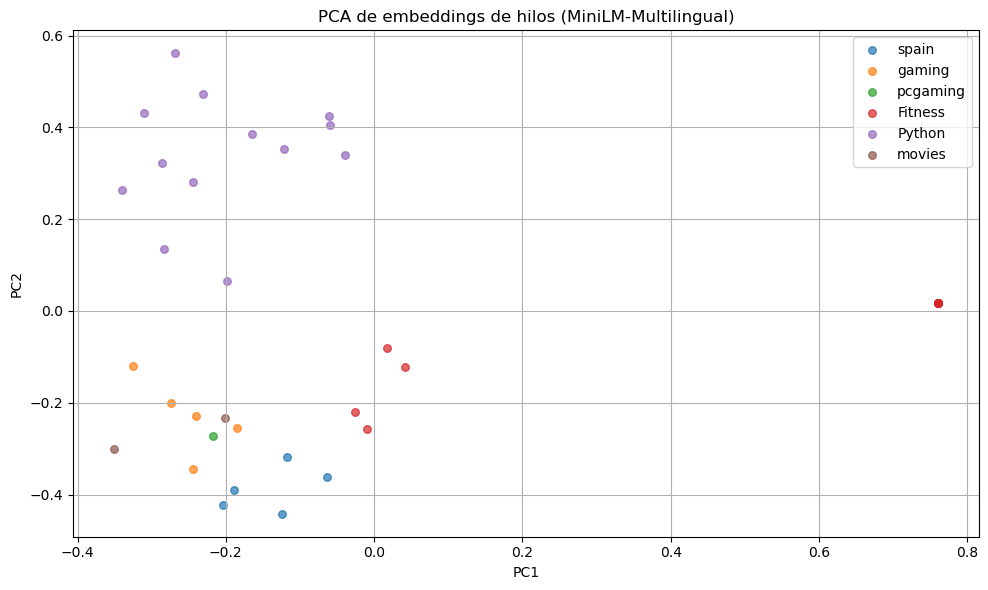

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json, os

# Cargar del modelo 
st_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# Leer hilos y concatenar comentarios (igual que antes)
subreddits = ['spain', 'gaming', 'pcgaming', 'Fitness', 'Python', 'movies']
threads = []
for sr in subreddits:
    fname = f"ejemplo_rubreddit_{sr}.json"
    if not os.path.exists(fname): continue
    data = json.load(open(fname, encoding='utf-8'))
    for hilo in data:
        hilo_id = hilo.get("title")[:50]
        text = " ".join(c["comment"] for c in hilo["comments"])
        threads.append({"id": hilo_id, "subreddit": sr, "text": text})
df = pd.DataFrame(threads)

# Obtener embeddings con Sentence-Transformers
sentences = df['text'].tolist()
embs = st_model.encode(sentences, batch_size=32, show_progress_bar=True, normalize_embeddings=True)
# embs es un array de shape (6 hilos, 384)

# Calcular similitud coseno
sim_matrix = cosine_similarity(embs)

# Para cada hilo, mostrar sus 3 vecinos más parecidos
top_k = 3
for i, row in df.iterrows():
    sims = sim_matrix[i]
    neigh = np.argsort(sims)[::-1]
    neigh = [j for j in neigh if j != i][:top_k]
    print(f"\nHilo: [{row['subreddit']}] {row['id']}")
    for j in neigh:
        print(f"   → ({sims[j]:.3f}) [{df.loc[j,'subreddit']}] {df.loc[j,'id']}")

# Visualización PCA en 2D
coords = PCA(n_components=2).fit_transform(embs)
plt.figure(figsize=(10,6))
for sr in subreddits:
    idx = df['subreddit'] == sr
    plt.scatter(coords[idx,0], coords[idx,1], label=sr, alpha=0.7, s=30)
plt.title("PCA de embeddings de hilos (MiniLM-Multilingual)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


- r/Python (puntos morados) forma un cluster claro: vocabulario muy técnico.
- r/Fitness (puntos rojos) aparece en la parte derecha: jerga de ejercicio y nutrición.
- r/gaming, r/pcgaming y r/movies (naranja, verde, marrón) se mezclan en la zona inferior izquierda: comparten términos de entretenimiento.
- r/spain (azul) también está cerca de esos tres: muchos comentarios en español.
- Algunos outliers indican hilos atípicos (texto muy largo, jerga específica o ruido).

### sentence-transformers/paraphrase-multilingual-mpnet-base-v2 - embeding de 768 dimensiones

c:\Users\hdhfh\miniconda3\envs\reddit-nlp\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\hdhfh\.cache\huggingface\hub\models--sentence-transformers--paraphrase-multilingual-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is n


Hilo: [spain] A large group of people in Barcelona sharing a sin
   → (0.597) [spain] Qué barbaridad
   → (0.574) [spain] Apagón masivo en toda la Península ibérica, 12:45a
   → (0.457) [spain] Wtf

Hilo: [spain] Apagón masivo en toda la Península ibérica, 12:45a
   → (0.574) [spain] A large group of people in Barcelona sharing a sin
   → (0.574) [spain] Qué barbaridad
   → (0.532) [spain] Wtf

Hilo: [spain] Qué barbaridad
   → (0.597) [spain] A large group of people in Barcelona sharing a sin
   → (0.574) [spain] Apagón masivo en toda la Península ibérica, 12:45a
   → (0.487) [spain] Wtf

Hilo: [spain] Me rechazaron el pago con tarjeta en un bar de Cud
   → (0.241) [gaming] 8bitdo stopping shipments of controllers to the US
   → (0.177) [Python] I built a Python framework for testing, stealth, a
   → (0.175) [gaming] The love of my life (who knows nothing about gamin

Hilo: [spain] Wtf
   → (0.532) [spain] Apagón masivo en toda la Península ibérica, 12:45a
   → (0.487) [spain] Qué ba

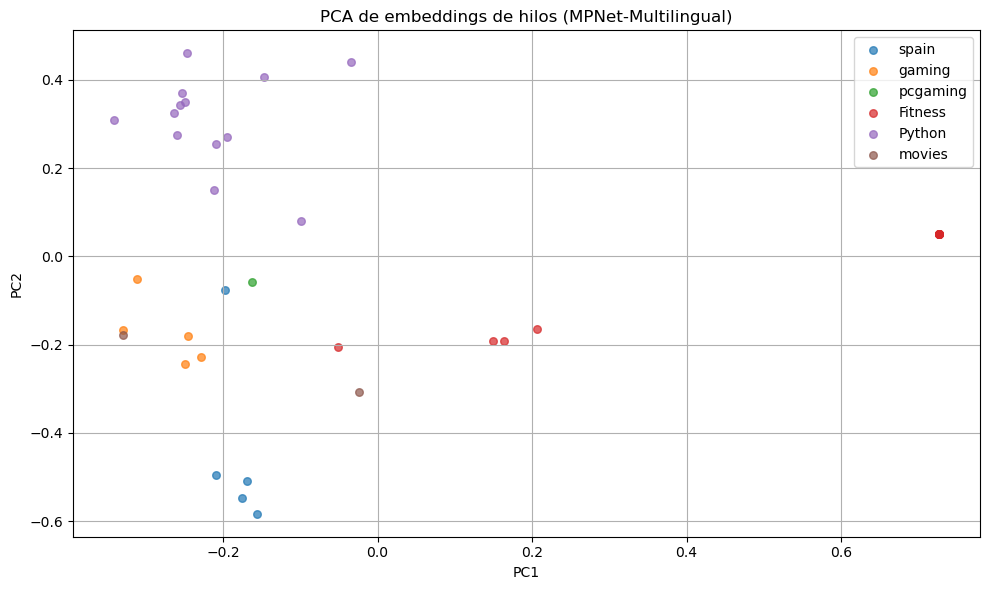

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json, os

st_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

subreddits = ['spain', 'gaming', 'pcgaming', 'Fitness', 'Python', 'movies']
threads = []
for sr in subreddits:
    fname = f"ejemplo_rubreddit_{sr}.json"
    if not os.path.exists(fname): continue
    data = json.load(open(fname, encoding='utf-8'))
    for hilo in data:
        hid = hilo['title'][:50]
        text = " ".join(c["comment"] for c in hilo["comments"])
        threads.append({"id": hid, "subreddit": sr, "text": text})
df = pd.DataFrame(threads)

# Obtener embeddings de 768d
sentences = df['text'].tolist()
embs = st_model.encode(
    sentences,
    batch_size=32,
    show_progress_bar=True,
    normalize_embeddings=True
)

# Calcular matriz de similitud coseno
sim_matrix = cosine_similarity(embs)

# Top‑3 vecinos por hilo
top_k = 3
for i, row in df.iterrows():
    sims = sim_matrix[i]
    neigh = np.argsort(sims)[::-1]
    neigh = [j for j in neigh if j != i][:top_k]
    print(f"\nHilo: [{row['subreddit']}] {row['id']}")
    for j in neigh:
        print(f"   → ({sims[j]:.3f}) [{df.loc[j,'subreddit']}] {df.loc[j,'id']}")

# Visualización PCA 2D
coords = PCA(n_components=2).fit_transform(embs)
plt.figure(figsize=(10,6))
for sr in subreddits:
    mask = df['subreddit']==sr
    plt.scatter(coords[mask,0], coords[mask,1], label=sr, alpha=0.7, s=30)
plt.title("PCA de embeddings de hilos (MPNet-Multilingual)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


Se pueden observar las mismas caracteristicas que con el modelo mas pequeño:
- Un vocabulario mas complejo en r/Python lo que lo hace diferenciarse
- Outlayers en el r/Fitness
- Comportamiento similar en el resto de los hilos

### all-mpnet-base-v2 - embeding de 768 dimensiones

c:\Users\hdhfh\miniconda3\envs\reddit-nlp\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\hdhfh\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Fallin


Hilo [spain] A large group of people in Barcelona sharing a sin
   → (0.510) [spain] Apagón masivo en toda la Península ibérica, 12:45a
   → (0.346) [spain] Wtf
   → (0.345) [spain] Qué barbaridad

Hilo [spain] Apagón masivo en toda la Península ibérica, 12:45a
   → (0.727) [spain] Wtf
   → (0.562) [spain] Qué barbaridad
   → (0.510) [spain] A large group of people in Barcelona sharing a sin

Hilo [spain] Qué barbaridad
   → (0.562) [spain] Apagón masivo en toda la Península ibérica, 12:45a
   → (0.467) [spain] Wtf
   → (0.440) [spain] Me rechazaron el pago con tarjeta en un bar de Cud

Hilo [spain] Me rechazaron el pago con tarjeta en un bar de Cud
   → (0.440) [spain] Qué barbaridad
   → (0.384) [spain] Apagón masivo en toda la Península ibérica, 12:45a
   → (0.301) [spain] A large group of people in Barcelona sharing a sin

Hilo [spain] Wtf
   → (0.727) [spain] Apagón masivo en toda la Península ibérica, 12:45a
   → (0.467) [spain] Qué barbaridad
   → (0.346) [spain] A large group 

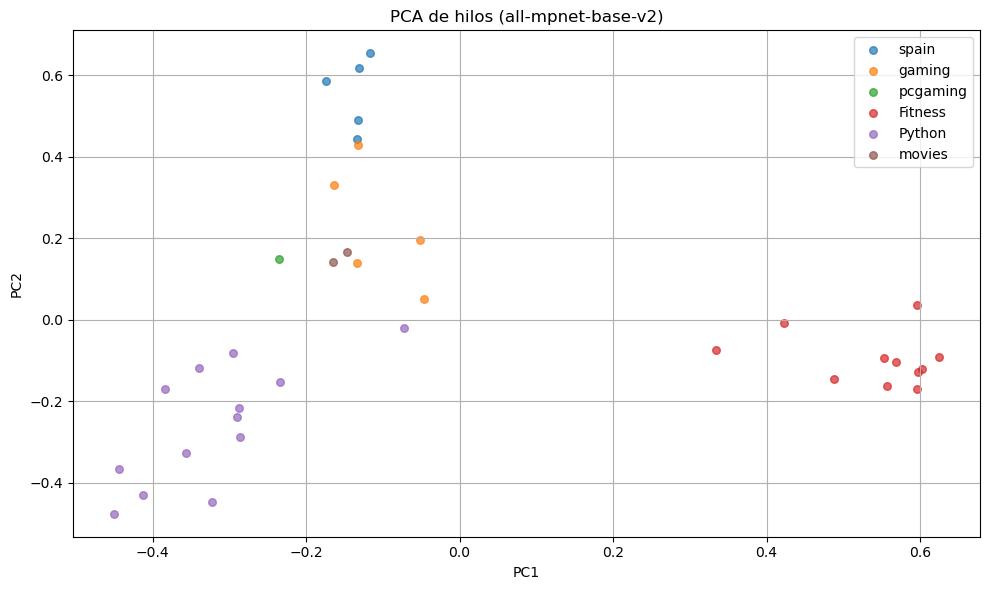

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json, os

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

subreddits = ['spain','gaming','pcgaming','Fitness','Python','movies']
threads = []
for sr in subreddits:
    fname = f"ejemplo_rubreddit_{sr}.json"
    if not os.path.exists(fname): continue
    data = json.load(open(fname, encoding='utf-8'))
    for hilo in data:
        hid = hilo['title'][:50]
        txt = " ".join(c["comment"] for c in hilo["comments"])
        threads.append({"id": hid, "subreddit": sr, "text": txt})
df = pd.DataFrame(threads)
sentences = df['text'].tolist()

# Encode (normalizado)
embs = model.encode(
    sentences,
    batch_size=32,
    show_progress_bar=True,
    normalize_embeddings=True
)
# Similitud coseno
sim_matrix = cosine_similarity(embs)

# Top‑3 vecinos por hilo
top_k = 3
for i, row in df.iterrows():
    sims = sim_matrix[i]
    neigh = np.argsort(sims)[::-1]
    neigh = [j for j in neigh if j != i][:top_k]
    print(f"\nHilo [{row['subreddit']}] {row['id']}")
    for j in neigh:
        print(f"   → ({sims[j]:.3f}) [{df.loc[j,'subreddit']}] {df.loc[j,'id']}")

# PCA 2D y visualización
coords = PCA(n_components=2).fit_transform(embs)
plt.figure(figsize=(10,6))
for sr in subreddits:
    mask = df['subreddit']==sr
    plt.scatter(coords[mask,0], coords[mask,1], label=sr, alpha=0.7, s=30)
plt.title("PCA de hilos (all-mpnet-base-v2)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


- Distincion de la clase Fitness
- Distincion de la clase Python
- Mezcla de las que clases restantes

Voy a comparar los tres modelos con la similitud Inter e Intra Cluster 

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import json, os

subreddits = ['spain','gaming','pcgaming','Fitness','Python','movies']
threads = []
for sr in subreddits:
    fname = f"ejemplo_rubreddit_{sr}.json"
    if not os.path.exists(fname): continue
    data = json.load(open(fname, encoding='utf-8'))
    for hilo in data:
        threads.append({
            "subreddit": sr,
            "text": " ".join(c["comment"] for c in hilo["comments"])
        })
df = pd.DataFrame(threads)
sentences = df['text'].tolist()
labels = df['subreddit'].values

# Función para calcular similitudes intra- e inter-clase
def intra_inter_sims(embs, labels):
    sim = cosine_similarity(embs)
    intra, inter = [], []
    n = len(labels)
    for i in range(n):
        for j in range(i+1, n):
            if labels[i] == labels[j]:
                intra.append(sim[i, j])
            else:
                inter.append(sim[i, j])
    return np.mean(intra), np.mean(inter)

# Modelos a comparar
models = {
    "MiniLM":      'paraphrase-multilingual-MiniLM-L12-v2',
    "MPNet-multi": 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2',
    "All-MPNet":   'sentence-transformers/all-mpnet-base-v2'
}

# Calcula y almacena resultados
results = []
for name, path in models.items():
    print(f"Procesando {name}...")
    model = SentenceTransformer(path)
    embs = model.encode(sentences,
                        batch_size=32,
                        show_progress_bar=False,
                        normalize_embeddings=True)
    intra_mean, inter_mean = intra_inter_sims(embs, labels)
    results.append({
        "Model": name,
        "Intra-similarity": intra_mean,
        "Inter-similarity": inter_mean
    })

# Mostrar comparativa
res_df = pd.DataFrame(results).set_index("Model").round(3)
print(res_df)


Procesando MiniLM...
Procesando MPNet-multi...
Procesando All-MPNet...
             Intra-similarity  Inter-similarity
Model                                          
MiniLM                  0.386             0.101
MPNet-multi             0.408             0.139
All-MPNet               0.341             0.057


Quiero que los hilos del mismo subreddit estén muy cerca (alta similitud intra‑clase) y que los hilos de subreddits distintos estén muy lejos (baja similitud inter‑clase).

- MiniLM y All‑MPNet empatan prácticamente en gap (~0.285 vs 0.284), ligeramente por encima de MPNet‑multi (0.269).

- MiniLM ofrece un muy buen compromiso: intra medio y inter bajo.

- All‑MPNet logra la inter‑similarity más baja (0.057), pero sacrifica algo de cohesión interna.

- MPNet‑multi tiene la mayor cohesión interna (0.408), pero también el solapamiento más alto (inter=0.139).

## 4 Análisis de subjetividad de los comentarios (0,5 puntos).
 

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
import torch
import json
import os
from tqdm import tqdm

# Modelos
sentiment_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
sentiment_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

emotion_model = AutoModelForSequenceClassification.from_pretrained("michellejieli/emotion_text_classifier")
emotion_tokenizer = AutoTokenizer.from_pretrained("michellejieli/emotion_text_classifier")

# Labels
sentiment_labels = ['negative', 'neutral', 'positive']
emotion_labels = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

# Funciones para análisis
def get_sentiment(text):
    tokens = sentiment_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        output = sentiment_model(**tokens)
    probs = softmax(output.logits, dim=1)[0]
    top_idx = torch.argmax(probs).item()
    return sentiment_labels[top_idx], probs.tolist()

def get_emotion(text):
    tokens = emotion_tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        output = emotion_model(**tokens)
    probs = softmax(output.logits, dim=1)[0]
    top_idx = torch.argmax(probs).item()
    return emotion_labels[top_idx], probs.tolist()

# Subreddits a procesar
subreddits = ['spain', 'gaming', 'pcgaming', 'Fitness', 'Python', 'movies']

for subreddit in subreddits:
    fname = f'ejemplo_rubreddit_{subreddit}.json'
    if not os.path.exists(fname):
        print(f"No existe: {fname}")
        continue

    with open(fname, 'r', encoding='utf-8') as f:
        data = json.load(f)

    for hilo in tqdm(data, desc=f"Procesando {subreddit}"):
        for comentario in hilo.get("comments", []):
            texto = comentario["comment"]
            sentimiento, probs_s = get_sentiment(texto)
            emocion, probs_e = get_emotion(texto)

            comentario["sentiment"] = sentimiento
            comentario["sentiment_probs"] = dict(zip(sentiment_labels, [round(p, 3) for p in probs_s]))
            comentario["emotion"] = emocion
            comentario["emotion_probs"] = dict(zip(emotion_labels, [round(p, 3) for p in probs_e]))

    # Guardar archivo modificado
    with open(f'comentarios_sentimiento_{subreddit}.json', 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)
    print(f"Guardado: comentarios_sentimiento_{subreddit}.json")


Procesando spain: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Guardado: comentarios_sentimiento_spain.json


Procesando gaming: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]


Guardado: comentarios_sentimiento_gaming.json


Procesando pcgaming: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it]


Guardado: comentarios_sentimiento_pcgaming.json


Procesando Fitness: 100%|██████████| 11/11 [00:31<00:00,  2.84s/it]


Guardado: comentarios_sentimiento_Fitness.json


Procesando Python: 100%|██████████| 13/13 [00:19<00:00,  1.47s/it]


Guardado: comentarios_sentimiento_Python.json


Procesando movies: 100%|██████████| 2/2 [00:07<00:00,  3.87s/it]

Guardado: comentarios_sentimiento_movies.json


Un ejemplo del funcionamiento es: 

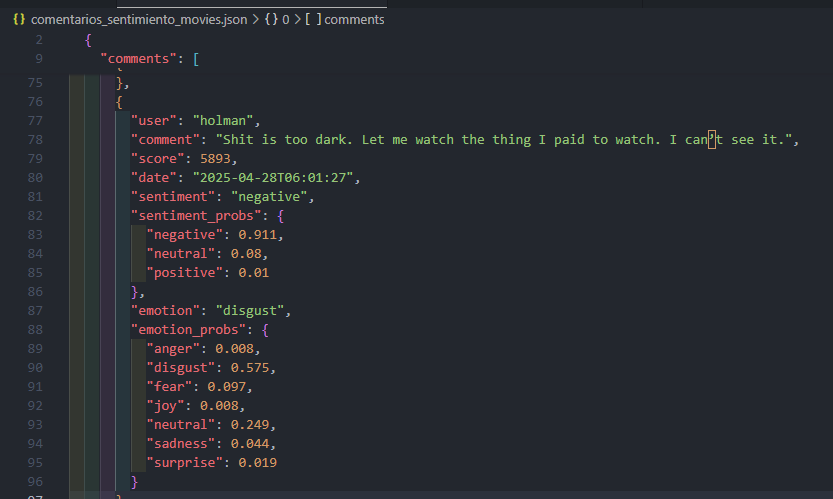


De donde se puede cocluir que el sentiemiento es negativo y que la emoción es asco

## 5 Resumen automático abstractivo (1,0 puntos) 

5.1) Usar un modelo ya entrenado para esta tarea, como mT5_multilingual_XLSum (https://huggingface.co/csebuetnlp/mT5_multilingual_XLSum) y
guardar el resumen de la descripción del hilo en el fichero JSON. 

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import re
import json
from tqdm import tqdm
import os

WHITESPACE_HANDLER = lambda k: re.sub(r'\s+', ' ', re.sub(r'\n+', ' ', k.strip())) #Esta linea no es necesaria pero la he sacado de la pagina de huggingface donde importa el modelo

# Cargar modelo y tokenizer
model_name = "csebuetnlp/mT5_multilingual_XLSum"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

def resumir_mt5(texto):
    entrada = WHITESPACE_HANDLER(texto)
    input_ids = tokenizer(
        [entrada],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=512
    )["input_ids"]

    output_ids = model.generate(
        input_ids=input_ids,
        max_length=84,
        no_repeat_ngram_size=2,
        num_beams=4
    )[0]

    resumen = tokenizer.decode(output_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    return resumen

# Subreddits a procesar
subreddits = ['spain', 'gaming', 'pcgaming', 'Fitness', 'Python', 'movies']

for subreddit in subreddits:
    fname = f'comentarios_sentimiento_{subreddit}.json'
    if not os.path.exists(fname): continue

    with open(fname, 'r', encoding='utf-8') as f:
        data = json.load(f)

    for hilo in tqdm(data, desc=f"Resumiendo (mT5) {subreddit}"):
        titulo = hilo.get("title", "")
        descripcion = hilo.get("description", "")
        comentarios = " ".join([com.get("comment", "") for com in hilo.get("comments", [])])
        texto = f"{titulo}. {descripcion}. {comentarios}"
        resumen = resumir_mt5(texto)
        hilo["resumen_mt5"] = resumen

    # Guardar JSON modificado
    with open(f'resumido_mt5_{subreddit}.json', 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)


c:\Users\hdhfh\miniconda3\envs\reddit-nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
c:\Users\hdhfh\miniconda3\envs\reddit-nlp\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\hdhfh\.cache\hugg

Ejemplo del funcionamiento:
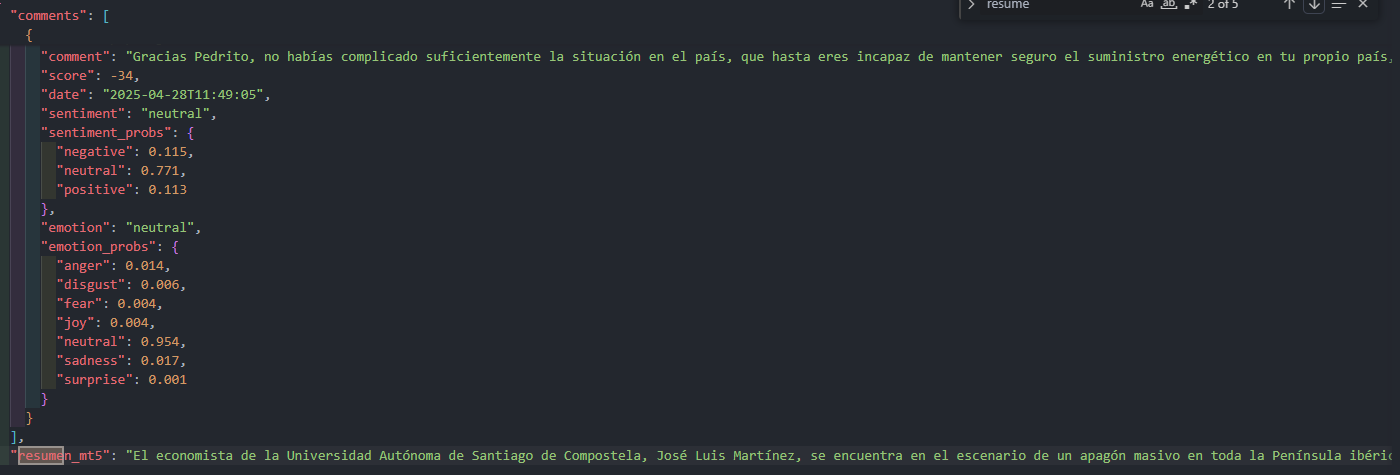

Aunque no todo ha ido muy bien hay cosas que las resume de una manera menos informativa simplemente haciendo la pregunta tal y como ve en un comentario



5.2) Usar SLMs (Small Large Models) como Gema (2B) o Llama 3.2 (1B), para obtener
el resumen mediante una estrategia (Zero-shot Learning, aprendizaje sin
ejemplos). Este resumen también se guardará en la descripción del hilo en el
fichero JSON. En esta tarea será necesario aplicar algunos pasos de postprocesamiento para obtener la respuesta y poder clasificarla como un enfoque
binario.

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import re
import json
from tqdm import tqdm
import os

WHITESPACE_HANDLER = lambda k: re.sub(r'\s+', '', re.sub(r'\n+', '', k.strip()))

# Configuración del modelo
MODEL_NAME = "google/gemma-2b"  
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)

# Crear pipeline de generación de texto
summarizer = pipeline(
    "text-generation", 
    model=model, 
    tokenizer=tokenizer,
    device=0  
)

def resumir_zero_shot(texto):
    # Limpiar texto
    entrada = WHITESPACE_HANDLER(texto)
    
    # Prompt para guiar al modelo (modo zero-shot)
    prompt = f"Resume este texto de forma concisa y clara: {entrada}"
    
    # Generar resumen (ajustar parámetros según necesidad)
    try:
        resumen = summarizer(
            prompt,
            max_new_tokens=84,  # Máximo de tokens nuevos
            min_new_tokens=20,
            do_sample=False,    # Determinístico para coherencia
            truncation=True,
            pad_token_id=tokenizer.eos_token_id  # Evitar errores de padding
        )[0]['generated_text']
    except Exception as e:
        resumen = f"[Error en resumen: {e}]"
    
    return resumen

subreddits = ['spain', 'gaming', 'pcgaming', 'Fitness', 'Python', 'movies']

# Procesar cada subreddit
for subreddit in subreddits:
    input_file = f'comentarios_sentimiento_{subreddit}.json'
    output_file = f'resumido_zero_shot_{subreddit}.json'
    
    if not os.path.exists(input_file):
        print(f"Archivo no encontrado: {input_file}")
        continue
    
    with open(input_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # Generar resúmenes para cada hilo
    for hilo in tqdm(data, desc=f"Resumen zero-shot ({subreddit})"):
        titulo = hilo.get("title", "")
        descripcion = hilo.get("description", "")
        comentarios = "".join([com.get("comment", "") for com in hilo.get("comments", [])])
        
        # Concatenar contenido relevante
        texto_completo = f"{titulo}. {descripcion}. {comentarios}"
        
        # Generar resumen
        hilo["resumen_zero_shot"] = resumir_zero_shot(texto_completo)
    
    # Guardar resultados actualizados
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)
    print(f"Guardado: {output_file}")

c:\Users\hdhfh\miniconda3\envs\reddit-nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.96s/it]
Device set to use cuda:0
Resumen zero-shot (spain):   0%|          | 0/5 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Resumen zero-shot (spain): 100%|██████████| 5/5 [05:14<00:00, 62.91s/it]


Guardado: resumido_zero_shot_spain.json


Resumen zero-shot (gaming): 100%|██████████| 5/5 [06:24<00:00, 76.87s/it]


Guardado: resumido_zero_shot_gaming.json


Resumen zero-shot (pcgaming):   0%|          | 0/1 [00:00<?, ?it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Resumen zero-shot (pcgaming): 100%|██████████| 1/1 [01:48<00:00, 108.85s/it]


Guardado: resumido_zero_shot_pcgaming.json


Resumen zero-shot (Fitness): 100%|██████████| 11/11 [27:12<00:00, 148.40s/it]


Guardado: resumido_zero_shot_Fitness.json


Resumen zero-shot (Python): 100%|██████████| 13/13 [20:14<00:00, 93.44s/it]


Guardado: resumido_zero_shot_Python.json


Resumen zero-shot (movies): 100%|██████████| 2/2 [03:54<00:00, 117.26s/it]

Guardado: resumido_zero_shot_movies.json


Este apartado lo he hecho con mi propia GPU (en el pipeline divice=0). La ejecución ha tardado 65minutos y los resultados no son los esperados la verdad pero creo que la logica del codigo es correcta

## 6 Detección de contenido inapropiado usando ZSL, FSL y Chain-of-thought (1,5 puntos)


In [2]:
# Usar PRAW para recopilar 10 hilos de r/OpinionesPolemicas con 50 comentarios cada uno
import praw
from tqdm import tqdm

reddit = praw.Reddit(
    client_id='_1WWMBLxGyn2mxo-xkDA4g',
    client_secret='nPQt-evDLFlh-9KUm5Sws-Uf_M1zqw',
    user_agent="Scraper 1.0 by/u/w4ity"
)

subreddit_name = "OpinionesPolemicas"
threads = []
for submission in reddit.subreddit(subreddit_name).hot(limit=10):  # 10 hilos
    comments = []
    submission.comments.replace_more(limit=0)
    for comment in tqdm(submission.comments.list(), desc=f"Procesando hilo {submission.id}"):
        if len(comments) >= 50:
            break
        comments.append({
            "comment": comment.body,
            "id": comment.id,
            "score": comment.score
        })
    threads.append({
        "title": submission.title,
        "comments": comments
    })

# Guardar en JSON
import json
with open("opiniones_polemicas.json", "w", encoding="utf-8") as f:
    json.dump(threads, f, ensure_ascii=False, indent=2)

Procesando hilo 1lerqc5:  16%|█▋        | 50/307 [00:00<?, ?it/s]


- Ahora que ya he obtenido los datos, he optado por usa la plataforma Kaggle, dentro de la cual se te verificas con el movil, tienes acceso a dos GPU T4.
- He importado el dataset desde VSCode a Kaggle, me tuve que verificar para que el modelo me funcione ya que es restringido el modelo de google/gema-2b.
- A contuniación modificao el codigo para que sea  mas optimo para que vaya en el entorno de kaggle y sea optimo para varias gpu; organizo en baches y asigno VRAM a cada uno le he decidido poner 8 RAM a cada.
- Le dejo el notebook en la entrega de como lo he hecho, pero voy a comentar aqui los resultados:
    - Alli hay que crear un dataframe, pero con un boton desde el propio menu se hace,

    - Teniendo el dataset, lo importo,

    - Importo el modelo aparte para ya corregir los error al ejecutarlo, con el token que se encuentra en una carpeta aparte,

- Funcionamiento:

    - Importo el dataset que necesito
    - Creo un bucle para los tres tipos de consultas
    - Escribo el prompt para cada uno de ellos y que sea una respuesta binaria Sí/No
    - Le doy parametros al modelo
    - Hago el flujo de procesar los threads, donde se carga el json se procesa de los tres tipos y se guarda en otro json
    - Una demostración por pantalla de los 10 primeros comentarios